In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [59]:
class DSO:
	def __init__(self, totalHours, marginalCost, unitSalePrice, maxPriceReference):
		self.totalHours = totalHours
		self.numberOfAggregators = 0
		self.marginalCost = marginalCost
		self.unitSalePrice = unitSalePrice
		self.maxPriceReference = maxPriceReference
		self.aggregators = []
		self.maxUtility = 0
		self.m = 0

	def addAggregator(self, aggregator):
		self.aggregators.append(aggregator)
		self.numberOfAggregators = self.numberOfAggregators + 1

	def getAggregators(self):
		return self.aggregators

	def Sfunction(self, aggregator, tIndex):
		return aggregator.maximumDemand[tIndex] * aggregator.maxPriceReference * (1 - np.exp(-aggregator.preferenceSatisfaction[tIndex] * (aggregator.bestLoadResponse[tIndex] / aggregator.nominalDemand[tIndex])))
	
	def CostFunction(self, aggregator, tIndex):
		return self.marginalCost[tIndex]
	
	def getLeftLimit(self):
		leftLimit = [0 for i in range(self.totalHours)]
		for i in range(self.totalHours):
			mx = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				mx = max(mx, agg.preferenceSatisfaction[i] * agg.maxPriceReference * np.exp(-agg.preferenceSatisfaction[i] * (agg.maximumDemand[i] / agg.nominalDemand[i])))
			leftLimit[i] = mx
		return leftLimit
	
	def getRightLimit(self):
		rightLimit = [0 for i in range(self.totalHours)]
		for i in range(self.totalHours):
			mx = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				mx = max(mx, agg.preferenceSatisfaction[i] * agg.maxPriceReference * np.exp(-agg.preferenceSatisfaction[i] * (agg.minimumDemand[i] / agg.nominalDemand[i])))
			rightLimit[i] = mx
		return rightLimit
	
	def generateUnitSalePrice(self):
		minPrice = self.marginalCost
		leftLimit = self.getLeftLimit()
		minPrice = np.minimum(minPrice, leftLimit)

		maxPrice = self.maxPriceReference
		rightLimit = self.getRightLimit()
		maxPrice = np.maximum(maxPrice, rightLimit)

		for i in range(self.totalHours):
			self.unitSalePrice[i] = random.uniform(minPrice[i], maxPrice[i])

	def generateM(self):
		m = 0
		mx = 0
		for i in range(self.totalHours):
			sum = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				sum = sum + agg.bestLoadResponse[i]
			mx = max(mx, sum)
		m = random.uniform(mx, mx*10)
		self.m = m

	def utilityFunction(self, m, theta, omega):
		# self.generateUnitSalePrice()
		self.generateM()
		print('m value:', self.m)

		# store value of INT_MIN in mx
		mx = -1000000000000
		for j in range(self.totalHours):
			sum = 0
			for i in range(self.numberOfAggregators):
				agg = self.aggregators[i]
				sum = sum + self.unitSalePrice[j] * agg.bestLoadResponse[j] - self.CostFunction(agg, j) * agg.bestLoadResponse[j] + omega * self.Sfunction(agg, j)
			sum = sum - theta*m
			mx = max(mx, sum)
		return mx

	def getPAR(self):
		# sum of all bestResponses for each hour for each aggregator
		sum = 0
		for i in range(self.totalHours):
			for j in range(self.numberOfAggregators):
				sum = sum + self.aggregators[j].bestLoadResponse[i]
		return (self.m * self.totalHours) / (sum)

class Aggregator:
	def __init__(self, totalHours, nominalDemand, minimumDemand, maximumDemand, maxPriceReference, preferenceSatisfaction):
		self.totalHours = totalHours
		self.nominalDemand = nominalDemand
		self.minimumDemand = minimumDemand
		self.maximumDemand = maximumDemand
		self.maxPriceReference = maxPriceReference
		self.preferenceSatisfaction = preferenceSatisfaction
		self.currentUtility = 0
		self.bestLoadResponse = []

	def utilityFunction(self, DSO):
		sum = 0
		for i in range(DSO.totalHours):
			sum = sum + DSO.Sfunction(self, i) - (DSO.unitSalePrice[i] * self.bestLoadResponse[i])
		return sum

	def optimalDR(self, DSO):
		self.bestLoadResponse = []
		for j in range(DSO.totalHours):
			self.bestLoadResponse.append((self.nominalDemand[j] / self.preferenceSatisfaction[j]) * (np.log((self.preferenceSatisfaction[j] * self.maxPriceReference) / DSO.unitSalePrice[j])))


In [60]:
datasetPath = '../dataset/'

In [61]:
numOfLA = 3
numOfHours = 50

In [62]:
nominalDemands = []
for i in range (0, 3):
	letter = chr(ord('A') + i)
	fileName = 'Home' + letter + '_hourly.csv'
	df = pd.read_csv(datasetPath + fileName)
	df = df[0:numOfHours]
	# Power is in kW
	nominalDemands.append(df['Power'].tolist())

In [63]:
LAs = []
# maxPriceReference = 30
maxPriceReference = 10000
for i in range(numOfLA):
	nominalDemand = nominalDemands[i]
	# find max of nominalDemand
	maxNominalDemand = max(nominalDemand)
	minimumDemand = np.random.uniform(0.0001, nominalDemand, numOfHours)
	maximumDemand = np.random.uniform(nominalDemand, maxNominalDemand+1, numOfHours)
	preferenceSatisfaction = np.random.uniform(0.1, 15, numOfHours)
	LAs.append(Aggregator(numOfHours, nominalDemand, minimumDemand, maximumDemand, maxPriceReference, preferenceSatisfaction))


In [64]:
# # print all the values for each LA
# for i in range(numOfLA):
# 	print("LA", i)
# 	print("nominal demand: ", LAs[i].nominalDemand)
# 	print("minimum demand: ", LAs[i].minimumDemand)
# 	print("maximum demand: ", LAs[i].maximumDemand)
# 	print("max price reference: ", LAs[i].maxPriceReference)
# 	print("preference satisfaction: ", LAs[i].preferenceSatisfaction)

In [65]:
marginalCost = np.random.randint(1, 7, numOfHours) # cent/kW
unitSalePrice = np.random.randint(1, 7, numOfHours) # cent/kWh
dso = DSO(numOfHours, marginalCost, unitSalePrice, maxPriceReference)

In [66]:
# append all the LAs to the DSO
for i in range(numOfLA):
	dso.addAggregator(LAs[i])

In [67]:
# # print all the values for the DSO
# print("DSO")
# print("marginal cost: ", dso.marginalCost)
# print("unit sale price: ", dso.unitSalePrice)


In [68]:
dso.generateUnitSalePrice()

In [69]:
# print Unit Sale Price
print("Unit Sale Price: ", dso.unitSalePrice)

Unit Sale Price:  [ 1580  4753 22298 15362  3870 29537  6563 11722 10561    89  3225 10197
 18801 41804 17420  6424 19260  1978 10270  9287  8401   655  1704  6050
  9310   772 36473  6954 12726 11920 43394 18413  3342  5852  9414 18465
 27887  5253  4868  2065 14765  2938  9830  6584  4917  9260  2004  2256
  6092 11997]


In [70]:
# DSO gives the price for each hour & each LA calculates the optimal DR
for i in range(numOfLA):
	# la = LAs[i]
	la = dso.aggregators[i]
	la.optimalDR(dso)

In [71]:
# print best load response for each LA
for i in range(numOfLA): # kWh
	print("LA", i)
	print("best load response: ", dso.aggregators[i].bestLoadResponse)

LA 0
best load response:  [0.15686341989659713, 0.10342984953950743, -0.5236214774002694, 0.06855712223264401, 0.1403116110926326, 0.029932057996674793, 0.212181911558598, 0.11913042941179126, 0.1728983983261616, 0.3177676301009402, 0.2564053650868139, 0.1344253075812363, 0.06706655793644223, -0.012820400118632147, 0.1392633291968008, 0.20327974941795268, 0.13826830365105078, 0.44233730744240407, 0.16926293055091085, -1.1427319208929334, 0.1730427812252461, 0.20011038557494212, 0.26727266035465175, 0.19838266279991462, 0.11535901650395156, 0.5002437900573179, 0.026483639227749108, 0.10644379125245024, 0.05734496037474252, 0.06412227810492857, 0.03553433335526577, 0.030794380411596062, 0.6021827339499293, 0.1352253012177611, 0.12364266800042903, -6.372778378926287, 0.0582591619096972, 0.18123860253854523, 0.17404139949306657, 0.13099364765297078, 0.08698488702970318, 0.17307857737984775, 0.15681639030311523, 0.11258687387337549, 0.1599446773301497, 0.10579802412989375, 0.133400287693253

In [72]:
# # check for negative values in each LA best load response
# for i in range(numOfLA):
# 	la = dso.aggregators[i]
# 	for j in range(numOfHours):
# 		if la.bestLoadResponse[j] < 0:
# 			print("LA", i, "best load response for hour", j, "is negative")

omega : weight factor for customer satisfaction

theta : weight factor for peak demand

m : peak demand > max of sum of load at all times

In [73]:
# DSO takes back the load response from each aggregator
m = np.random.randint(1, 100)
omega = 5
theta = 0.01

dso.maxUtility = dso.utilityFunction(m, theta, omega)
dso.maxUtility

m value: 49.71544081966056


811405.0996999281

In [74]:
# DSO takes back the load response from each aggregator
m = np.random.randint(1, 100)
omega = 6
theta = 0.02

dso.maxUtility = dso.utilityFunction(m, theta, omega)
dso.maxUtility

m value: 37.30595844369549


968980.8564079625

In [75]:
# DSO takes back the load response from each aggregator
m = np.random.randint(1, 100)
omega = 2
theta = 0.1

dso.maxUtility = dso.utilityFunction(m, theta, omega)
dso.maxUtility

m value: 41.72518119981709


338674.06957582495

In [76]:
# print utility for each house
for i in range(numOfLA):
	print("LA", i)
	ut = LAs[i].utilityFunction(dso)
	print("utility: ", ut)

LA 0
utility:  347975.7045979477
LA 1
utility:  2407264.4946874804
LA 2
utility:  1456222.2824489195


In [77]:
dso.getPAR()

52.525917866443976

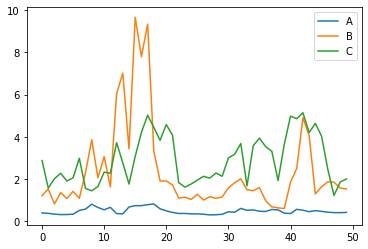

In [78]:
# plot nominal demand of each LA
for i in range(numOfLA):
	plt.plot(LAs[i].nominalDemand)
plt.legend([chr(ord('A') + i) for i in range(numOfLA)])
plt.show()

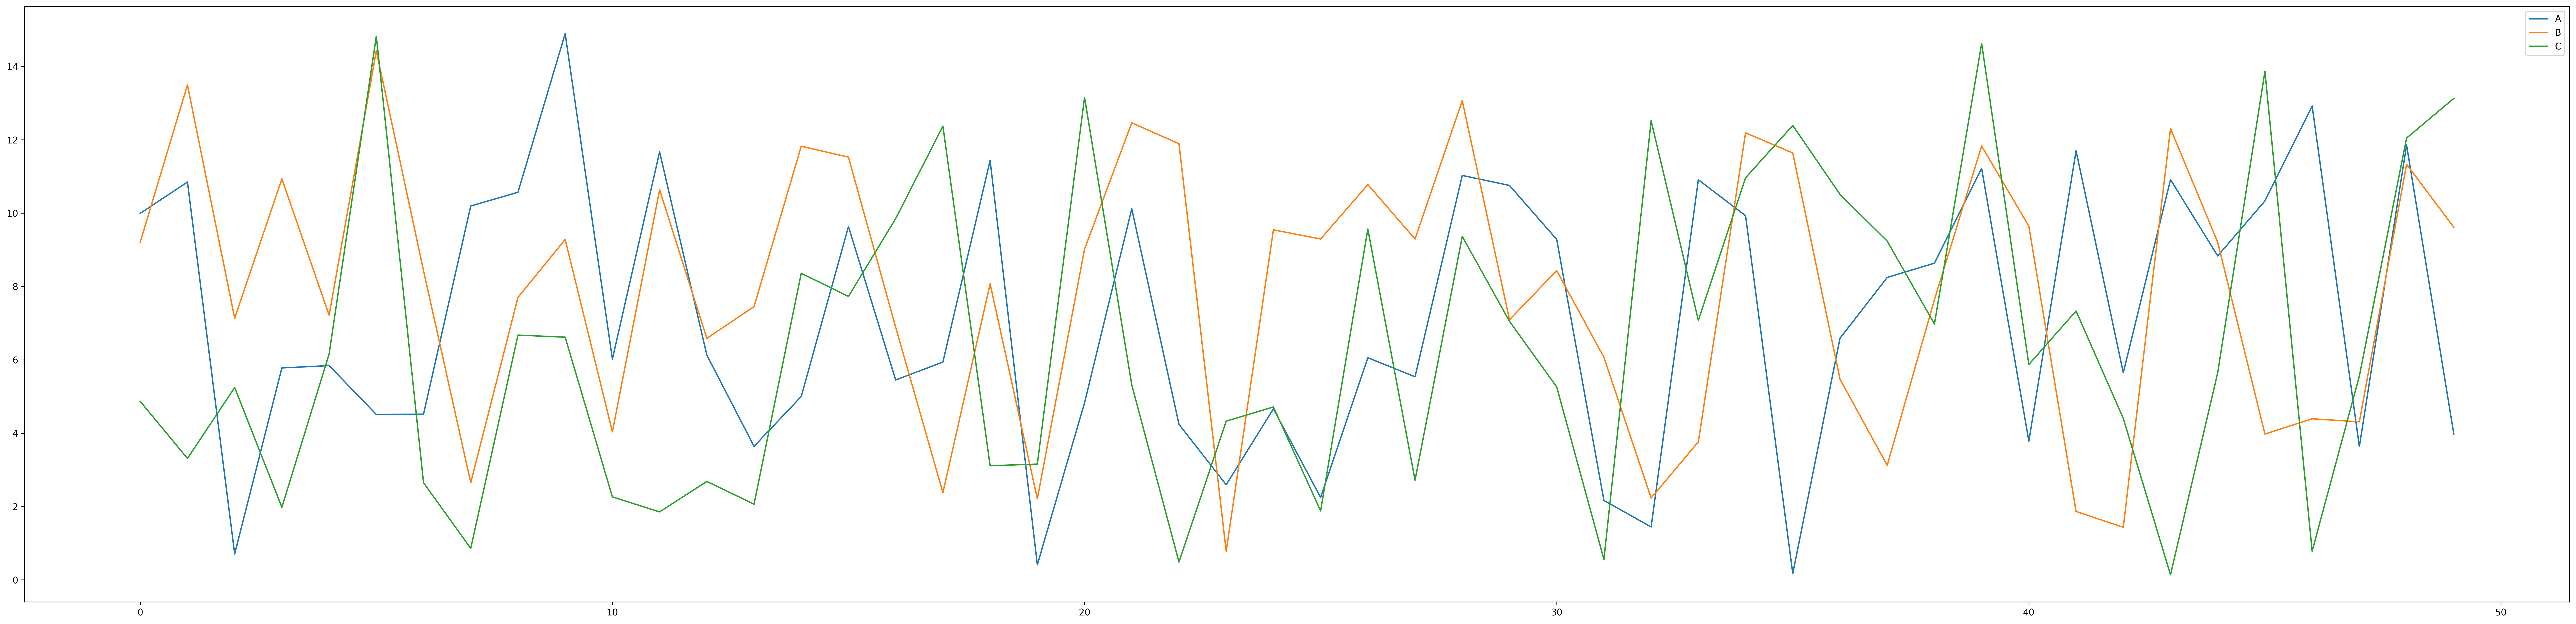

In [79]:
# plot user pref of each LA
plt.figure(figsize=(50, 12), dpi=300)
for i in range(numOfLA):
	plt.plot(LAs[i].preferenceSatisfaction)
plt.legend([chr(ord('A') + i) for i in range(numOfLA)])
plt.show()

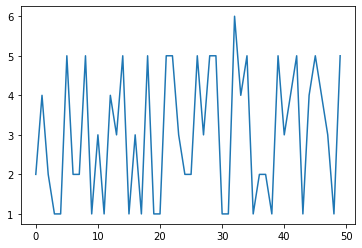

In [80]:
# plot marginal cost
plt.plot(dso.marginalCost)
plt.show()

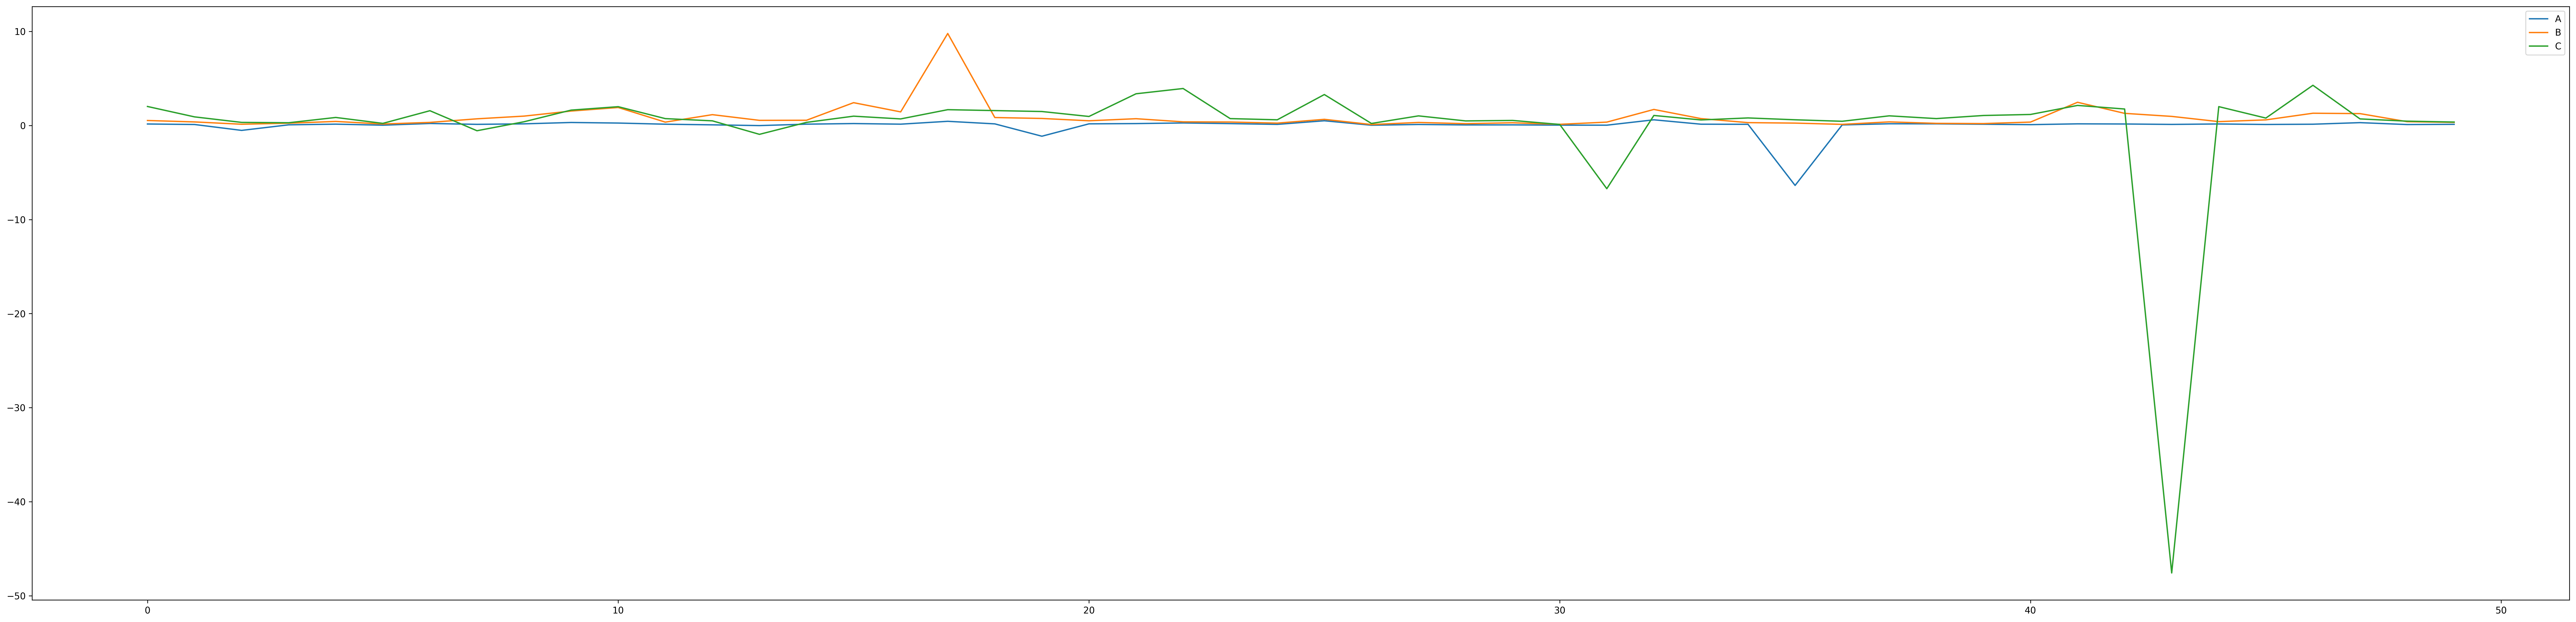

In [81]:
# plot bestLoadResponse of each LA
plt.figure(figsize=(50, 12), dpi=300)
for i in range(numOfLA):
	plt.plot(LAs[i].bestLoadResponse)
plt.legend([chr(ord('A') + i) for i in range(numOfLA)])
plt.show()